<a href="https://colab.research.google.com/github/Beard31/Deep-Dive-Data-Science-Projects/blob/main/Spotify_Popularity_Prediction_Beard_Final_Draft_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 4: Music Popularity Prediction


###Business Problem
-This project will take data features collected from songs that have been on the Top 200 Weekly (Global) charts of Spotify in 2020 & 2021. The popularity of the song will be predicted using a tree-based regression model trained on these features.

### Goal/Data Science Problem:

- Minimize the cross-validated ***root mean squared error ( RMSE )*** when predicting the popularity of a new song.

- Determine the importance of the features in driving the regression result.
The project will be done using tree-based regression techniques as covered in class. The hyperparameters of the trees should be carefully selected to avoid over-fitting.

- Supervised Classification
  - Random Forest Regressor

- Spotify's metric for Dancibility is a combination of elements, including tempo, rhythm and beat.
- Spotify's metric for Artist Followers are based on how many followers they have within the app. They are notified within the app when new tracks come out.

### Targets
- Dancibility
- Artist Followers

## Data Collection/Sources


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from google.cloud import bigquery
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor


### File Path

In [2]:
url = "https://ddc-datascience.s3.amazonaws.com/Projects/Project.4-Spotify/Data/Spotify.csv"
!curl -s -I {url}

HTTP/1.1 200 OK
x-amz-id-2: KWR9CysY8md8nVMyMMHmw02JJZXGAOG3wxnv3KVWp7w0NCNagPNyKTO+ZauqCeQ+MiGpgeZ2N2o=
x-amz-request-id: 9TA9BWGXD1AWACAC
Date: Mon, 03 Mar 2025 03:14:55 GMT
Last-Modified: Wed, 04 Oct 2023 17:23:56 GMT
ETag: "65b9875b11e0d7ea03ee2af024f45e99"
x-amz-server-side-encryption: AES256
Accept-Ranges: bytes
Content-Type: text/csv
Content-Length: 738124
Server: AmazonS3



In [3]:
!curl -s -O {url}

In [4]:
ls -la

total 740
drwxr-xr-x 1 root root   4096 Mar  3 03:14 ./
drwxr-xr-x 1 root root   4096 Mar  3 03:13 ../
drwxr-xr-x 4 root root   4096 Feb 27 14:21 .config/
drwxr-xr-x 1 root root   4096 Feb 27 14:22 sample_data/
-rw-r--r-- 1 root root 738124 Mar  3 03:14 Spotify.csv


In [5]:
!head -1 Spotify.csv | tr , '\n' | cat -n

     1	Index
     2	Highest Charting Position
     3	Number of Times Charted
     4	Week of Highest Charting
     5	Song Name
     6	Streams
     7	Artist
     8	Artist Followers
     9	Song ID
    10	Genre
    11	Release Date
    12	Weeks Charted
    13	Popularity
    14	Danceability
    15	Energy
    16	Loudness
    17	Speechiness
    18	Acousticness
    19	Liveness
    20	Tempo
    21	Duration (ms)
    22	Valence
    23	Chord


### Load Data

In [6]:
df = pd.read_csv(url)
df.head()

,Index,Highest Charting Position,Number of Times Charted,Week of Highest Charting,Song Name,Streams,Artist,Artist Followers,Song ID,Genre,...,Danceability,Energy,Loudness,Speechiness,Acousticness,Liveness,Tempo,Duration (ms),Valence,Chord
0,1,1,8,2021-07-23--2021-07-30,Beggin',"48,633,449",Måneskin,3377762,3Wrjm47oTz2sjIgck11l5e,"['indie rock italiano', 'italian pop']",...,0.714,0.8,-4.808,0.0504,0.127,0.359,134.002,211560,0.589,B
1,2,2,3,2021-07-23--2021-07-30,STAY (with Justin Bieber),"47,248,719",The Kid LAROI,2230022,5HCyWlXZPP0y6Gqq8TgA20,['australian hip hop'],...,0.591,0.764,-5.484,0.0483,0.0383,0.103,169.928,141806,0.478,C#/Db
2,3,1,11,2021-06-25--2021-07-02,good 4 u,"40,162,559",Olivia Rodrigo,6266514,4ZtFanR9U6ndgddUvNcjcG,['pop'],...,0.563,0.664,-5.044,0.154,0.335,0.0849,166.928,178147,0.688,A
3,4,3,5,2021-07-02--2021-07-09,Bad Habits,"37,799,456",Ed Sheeran,83293380,6PQ88X9TkUIAUIZJHW2upE,"['pop', 'uk pop']",...,0.808,0.897,-3.712,0.0348,0.0469,0.364,126.026,231041,0.591,B
4,5,5,1,2021-07-23--2021-07-30,INDUSTRY BABY (feat. Jack Harlow),"33,948,454",Lil Nas X,5473565,27NovPIUIRrOZoCHxABJwK,"['lgbtq+ hip hop', 'pop rap']",...,0.736,0.704,-7.409,0.0615,0.0203,0.0501,149.995,212000,0.894,D#/Eb


In [7]:
df_copy = df.copy()

### Quick view of meta data

In [8]:
df_copy.shape

(1556, 23)

- There are 23 rows and 1556 columns

- Let's get an overview of the data frame structure.

In [9]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1556 entries, 0 to 1555
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Index                      1556 non-null   int64 
 1   Highest Charting Position  1556 non-null   int64 
 2   Number of Times Charted    1556 non-null   int64 
 3   Week of Highest Charting   1556 non-null   object
 4   Song Name                  1556 non-null   object
 5   Streams                    1556 non-null   object
 6   Artist                     1556 non-null   object
 7   Artist Followers           1556 non-null   object
 8   Song ID                    1556 non-null   object
 9   Genre                      1556 non-null   object
 10  Release Date               1556 non-null   object
 11  Weeks Charted              1556 non-null   object
 12  Popularity                 1556 non-null   object
 13  Danceability               1556 non-null   object
 14  Energy  

- We have a mixture of objects and integers
- Summary of stats

In [10]:
df_copy.describe(include="all").transpose()

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Index,1556.0,NaN,NaN,NaN,778.5,449.322824,1.0,389.75,778.5,1167.25,1556.0
Highest Charting Position,1556.0,NaN,NaN,NaN,87.744216,58.147225,1.0,37.0,80.0,137.0,200.0
Number of Times Charted,1556.0,NaN,NaN,NaN,10.66838,16.360546,1.0,1.0,4.0,12.0,142.0
Week of Highest Charting,1556,83,2019-12-27--2020-01-03,89,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Song Name,1556,1556,Beggin',1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Streams,1556,1556,"48,633,449",1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Artist,1556,716,Taylor Swift,52,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Artist Followers,1556,600,42227614,52,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Song ID,1556,1517,,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Genre,1556,395,[],75,NaN,NaN,NaN,NaN,NaN,NaN,NaN


- Lets check for Nulls

In [11]:
df_copy.isnull().sum()

,0
Index,0
Highest Charting Position,0
Number of Times Charted,0
Week of Highest Charting,0
Song Name,0
Streams,0
Artist,0
Artist Followers,0
Song ID,0
Genre,0


- There's 0 Nulls

In [12]:
df_copy.nunique().sort_values(ascending=False)/ df_copy.shape[0]

,0
Index,1.000000
Song Name,1.000000
Streams,1.000000
Song ID,0.974936
Duration (ms),0.955013
Tempo,0.938946
Loudness,0.895887
Acousticness,0.620180
Weeks Charted,0.498072
Speechiness,0.496144


- How many of each data type?

In [13]:
df_copy.dtypes.value_counts()

,count
object,20
int64,3


## Data Cleaning


In [14]:
df_copy.drop_duplicates(inplace=True)
df_copy.duplicated().sum()

0

In [15]:
df_copy.shape

(1556, 23)

- We can see there are multiple columns with white space that must be handled

In [16]:
for col in df_copy.columns:
  if pd.api.types.is_string_dtype(df_copy[col]):
    whitespace_count = df_copy[col].str.contains(r'\s', regex=True, na=False).sum()
    if whitespace_count > 0:
        print(f"Column '{col}' has {whitespace_count} values with whitespace")

Column 'Song Name' has 1169 values with whitespace
Column 'Artist' has 1228 values with whitespace
Column 'Artist Followers' has 11 values with whitespace
Column 'Song ID' has 11 values with whitespace
Column 'Genre' has 1448 values with whitespace
Column 'Release Date' has 11 values with whitespace
Column 'Weeks Charted' has 1047 values with whitespace
Column 'Popularity' has 11 values with whitespace
Column 'Danceability' has 11 values with whitespace
Column 'Energy' has 11 values with whitespace
Column 'Loudness' has 11 values with whitespace
Column 'Speechiness' has 11 values with whitespace
Column 'Acousticness' has 11 values with whitespace
Column 'Liveness' has 11 values with whitespace
Column 'Tempo' has 11 values with whitespace
Column 'Duration (ms)' has 11 values with whitespace
Column 'Valence' has 11 values with whitespace
Column 'Chord' has 11 values with whitespace


In [17]:
df_copy.head()

,Index,Highest Charting Position,Number of Times Charted,Week of Highest Charting,Song Name,Streams,Artist,Artist Followers,Song ID,Genre,...,Danceability,Energy,Loudness,Speechiness,Acousticness,Liveness,Tempo,Duration (ms),Valence,Chord
0,1,1,8,2021-07-23--2021-07-30,Beggin',"48,633,449",Måneskin,3377762,3Wrjm47oTz2sjIgck11l5e,"['indie rock italiano', 'italian pop']",...,0.714,0.8,-4.808,0.0504,0.127,0.359,134.002,211560,0.589,B
1,2,2,3,2021-07-23--2021-07-30,STAY (with Justin Bieber),"47,248,719",The Kid LAROI,2230022,5HCyWlXZPP0y6Gqq8TgA20,['australian hip hop'],...,0.591,0.764,-5.484,0.0483,0.0383,0.103,169.928,141806,0.478,C#/Db
2,3,1,11,2021-06-25--2021-07-02,good 4 u,"40,162,559",Olivia Rodrigo,6266514,4ZtFanR9U6ndgddUvNcjcG,['pop'],...,0.563,0.664,-5.044,0.154,0.335,0.0849,166.928,178147,0.688,A
3,4,3,5,2021-07-02--2021-07-09,Bad Habits,"37,799,456",Ed Sheeran,83293380,6PQ88X9TkUIAUIZJHW2upE,"['pop', 'uk pop']",...,0.808,0.897,-3.712,0.0348,0.0469,0.364,126.026,231041,0.591,B
4,5,5,1,2021-07-23--2021-07-30,INDUSTRY BABY (feat. Jack Harlow),"33,948,454",Lil Nas X,5473565,27NovPIUIRrOZoCHxABJwK,"['lgbtq+ hip hop', 'pop rap']",...,0.736,0.704,-7.409,0.0615,0.0203,0.0501,149.995,212000,0.894,D#/Eb


- Lets get rid of the white space and special cases

In [18]:
# Gets rid of special cases and white spaces
df_clean1 = df_copy.replace(r'[\s, _-]+', '', regex=True).applymap(
    lambda x: int(x) if isinstance(x, float) and x.is_integer() else x
)
df_clean1.head()

<ipython-input-18-8e7f929d3d26>:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_clean1 = df_copy.replace(r'[\s, _-]+', '', regex=True).applymap(


,Index,Highest Charting Position,Number of Times Charted,Week of Highest Charting,Song Name,Streams,Artist,Artist Followers,Song ID,Genre,...,Danceability,Energy,Loudness,Speechiness,Acousticness,Liveness,Tempo,Duration (ms),Valence,Chord
0,1,1,8,2021072320210730,Beggin',48633449,Måneskin,3377762,3Wrjm47oTz2sjIgck11l5e,['indierockitaliano''italianpop'],...,0.714,0.8,4.808,0.0504,0.127,0.359,134.002,211560,0.589,B
1,2,2,3,2021072320210730,STAY(withJustinBieber),47248719,TheKidLAROI,2230022,5HCyWlXZPP0y6Gqq8TgA20,['australianhiphop'],...,0.591,0.764,5.484,0.0483,0.0383,0.103,169.928,141806,0.478,C#/Db
2,3,1,11,2021062520210702,good4u,40162559,OliviaRodrigo,6266514,4ZtFanR9U6ndgddUvNcjcG,['pop'],...,0.563,0.664,5.044,0.154,0.335,0.0849,166.928,178147,0.688,A
3,4,3,5,2021070220210709,BadHabits,37799456,EdSheeran,83293380,6PQ88X9TkUIAUIZJHW2upE,['pop''ukpop'],...,0.808,0.897,3.712,0.0348,0.0469,0.364,126.026,231041,0.591,B
4,5,5,1,2021072320210730,INDUSTRYBABY(feat.JackHarlow),33948454,LilNasX,5473565,27NovPIUIRrOZoCHxABJwK,['lgbtq+hiphop''poprap'],...,0.736,0.704,7.409,0.0615,0.0203,0.0501,149.995,212000,0.894,D#/Eb


- Lets check for white space to make sure its gone and it is good

In [47]:
for col in df_clean1.columns:
  if pd.api.types.is_string_dtype(df_clean1[col]):
    whitespace_count = df_copy[col].str.contains(r'\s', regex=True, na=False).sum()
    if whitespace_count > 0:
        print(f"Column '{col}' has {whitespace_count} values with whitespace")

In [20]:
df_clean1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1556 entries, 0 to 1555
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Index                      1556 non-null   int64 
 1   Highest Charting Position  1556 non-null   int64 
 2   Number of Times Charted    1556 non-null   int64 
 3   Week of Highest Charting   1556 non-null   object
 4   Song Name                  1556 non-null   object
 5   Streams                    1556 non-null   object
 6   Artist                     1556 non-null   object
 7   Artist Followers           1556 non-null   object
 8   Song ID                    1556 non-null   object
 9   Genre                      1556 non-null   object
 10  Release Date               1556 non-null   object
 11  Weeks Charted              1556 non-null   object
 12  Popularity                 1556 non-null   object
 13  Danceability               1556 non-null   object
 14  Energy  

- Lets conert the data in to a more usable form - floats

In [21]:
# Finding all object dtypes in df_clean1
object_columns = df_clean1.select_dtypes(include=['object']).columns

for col in object_columns:
    try:
      # Attempt to convert to numeric first. If successful
      df_clean1[col] = pd.to_numeric(df_clean1[col], errors='coerce')
      df_clean1[col] = df_clean1[col].fillna(0)
      # Handle potential errors (e.g., non-numeric values) gracefully.
    except (ValueError, TypeError):
        print(f"Column '{col}' has value error.")

df_clean1.head()

,Index,Highest Charting Position,Number of Times Charted,Week of Highest Charting,Song Name,Streams,Artist,Artist Followers,Song ID,Genre,...,Danceability,Energy,Loudness,Speechiness,Acousticness,Liveness,Tempo,Duration (ms),Valence,Chord
0,1,1,8,2021072320210730,0.0,48633449,0.0,3377762.0,0.0,0.0,...,0.714,0.800,4.808,0.0504,0.1270,0.3590,134.002,211560.0,0.589,0.0
1,2,2,3,2021072320210730,0.0,47248719,0.0,2230022.0,0.0,0.0,...,0.591,0.764,5.484,0.0483,0.0383,0.1030,169.928,141806.0,0.478,0.0
2,3,1,11,2021062520210702,0.0,40162559,0.0,6266514.0,0.0,0.0,...,0.563,0.664,5.044,0.1540,0.3350,0.0849,166.928,178147.0,0.688,0.0
3,4,3,5,2021070220210709,0.0,37799456,0.0,83293380.0,0.0,0.0,...,0.808,0.897,3.712,0.0348,0.0469,0.3640,126.026,231041.0,0.591,0.0
4,5,5,1,2021072320210730,0.0,33948454,0.0,5473565.0,0.0,0.0,...,0.736,0.704,7.409,0.0615,0.0203,0.0501,149.995,212000.0,0.894,0.0


In [22]:
df_clean1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1556 entries, 0 to 1555
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Index                      1556 non-null   int64  
 1   Highest Charting Position  1556 non-null   int64  
 2   Number of Times Charted    1556 non-null   int64  
 3   Week of Highest Charting   1556 non-null   int64  
 4   Song Name                  1556 non-null   float64
 5   Streams                    1556 non-null   int64  
 6   Artist                     1556 non-null   float64
 7   Artist Followers           1556 non-null   float64
 8   Song ID                    1556 non-null   float64
 9   Genre                      1556 non-null   float64
 10  Release Date               1556 non-null   float64
 11  Weeks Charted              1556 non-null   float64
 12  Popularity                 1556 non-null   float64
 13  Danceability               1556 non-null   float

In [23]:
df_clean1.shape

(1556, 23)

- Lets check for highly correlated items related to Popularity

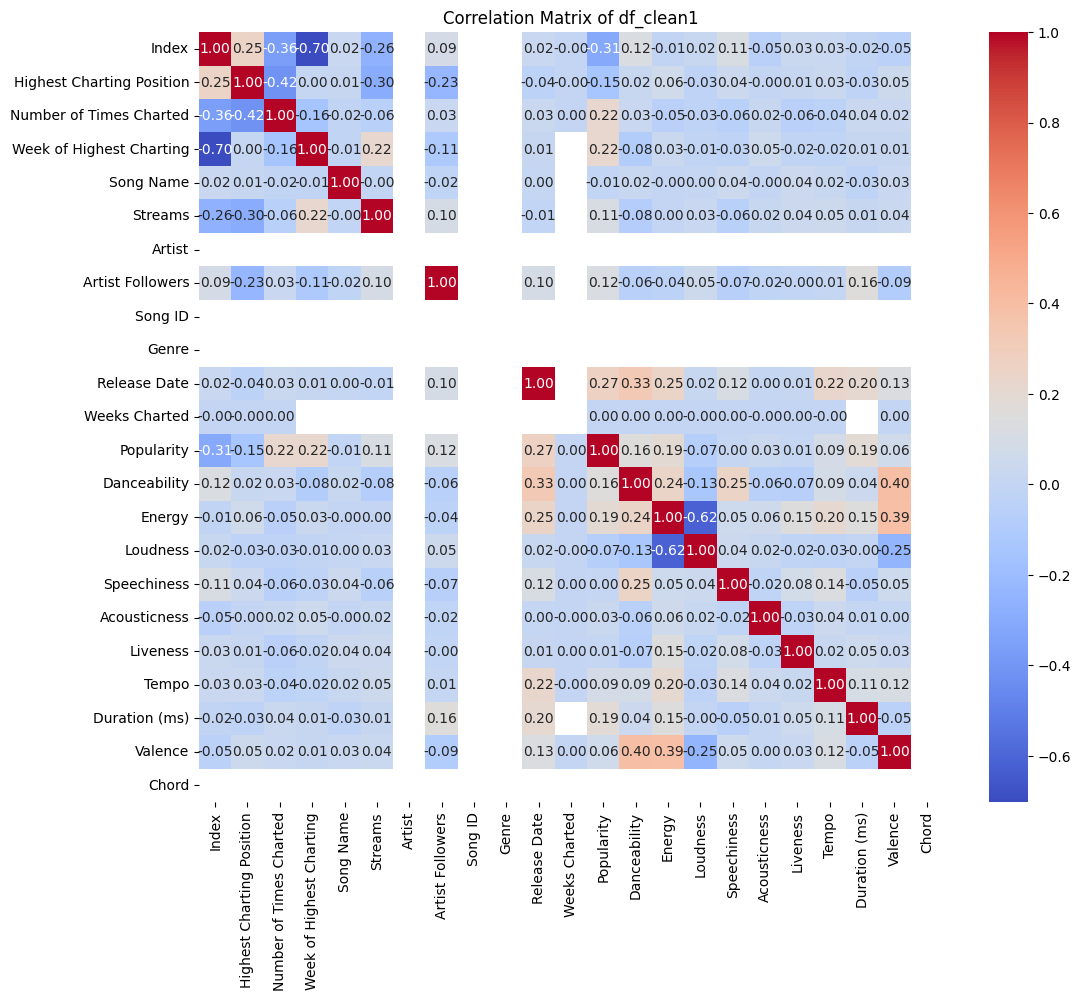

In [24]:
plt.figure(figsize=(12, 10))
sns.heatmap(df_clean1.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of df_clean1')
plt.show()

- Highest Charting Position, Week of Highest Charting, Streams, Artist Followeres, Release Date, Danceability and Energy are highly corralated with Popularity.

- We are predicting the popularity of a song before it comes out; so lets drop the columns that are features of a song after the song is released

- Artist Followers and Danceability is highly correleted to Popularity so I will use it for my target

In [25]:
# drop Index, Highest Charting Position, Number of Times Charted, Week of Highest Charting, Song Name, Streams, Release Date, Popularity, Weeks charted from df_clean1

columns_to_drop = ['Index', 'Highest Charting Position', 'Number of Times Charted',
                   'Week of Highest Charting', 'Song Name','Streams', 'Weeks Charted', 'Popularity']


# Check if columns exist before dropping
columns_to_drop = [col for col in columns_to_drop if col in df_clean1.columns]

if columns_to_drop:
    df_clean1 = df_clean1.drop(columns=columns_to_drop)


In [26]:
df_clean1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1556 entries, 0 to 1555
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Artist            1556 non-null   float64
 1   Artist Followers  1556 non-null   float64
 2   Song ID           1556 non-null   float64
 3   Genre             1556 non-null   float64
 4   Release Date      1556 non-null   float64
 5   Danceability      1556 non-null   float64
 6   Energy            1556 non-null   float64
 7   Loudness          1556 non-null   float64
 8   Speechiness       1556 non-null   float64
 9   Acousticness      1556 non-null   float64
 10  Liveness          1556 non-null   float64
 11  Tempo             1556 non-null   float64
 12  Duration (ms)     1556 non-null   float64
 13  Valence           1556 non-null   float64
 14  Chord             1556 non-null   float64
dtypes: float64(15)
memory usage: 182.5 KB


In [27]:
df_clean1.head()

,Artist,Artist Followers,Song ID,Genre,Release Date,Danceability,Energy,Loudness,Speechiness,Acousticness,Liveness,Tempo,Duration (ms),Valence,Chord
0,0.0,3377762.0,0.0,0.0,20171208.0,0.714,0.800,4.808,0.0504,0.1270,0.3590,134.002,211560.0,0.589,0.0
1,0.0,2230022.0,0.0,0.0,20210709.0,0.591,0.764,5.484,0.0483,0.0383,0.1030,169.928,141806.0,0.478,0.0
2,0.0,6266514.0,0.0,0.0,20210521.0,0.563,0.664,5.044,0.1540,0.3350,0.0849,166.928,178147.0,0.688,0.0
3,0.0,83293380.0,0.0,0.0,20210625.0,0.808,0.897,3.712,0.0348,0.0469,0.3640,126.026,231041.0,0.591,0.0
4,0.0,5473565.0,0.0,0.0,20210723.0,0.736,0.704,7.409,0.0615,0.0203,0.0501,149.995,212000.0,0.894,0.0


- More Feature Selection lets drop the columns with 0s

In [28]:
# drop all columns with 0 in them

for col in df_clean1.columns:
    if (df_clean1[col] == 0).all():
        df_clean1 = df_clean1.drop(col, axis=1)
        print(f"Column '{col}' has been dropped.")
    else:
        print(f"Column '{col}' contains non-zero values.")



Column 'Artist' has been dropped.
Column 'Artist Followers' contains non-zero values.
Column 'Song ID' has been dropped.
Column 'Genre' has been dropped.
Column 'Release Date' contains non-zero values.
Column 'Danceability' contains non-zero values.
Column 'Energy' contains non-zero values.
Column 'Loudness' contains non-zero values.
Column 'Speechiness' contains non-zero values.
Column 'Acousticness' contains non-zero values.
Column 'Liveness' contains non-zero values.
Column 'Tempo' contains non-zero values.
Column 'Duration (ms)' contains non-zero values.
Column 'Valence' contains non-zero values.
Column 'Chord' has been dropped.


In [29]:
df_clean1.head()

,Artist Followers,Release Date,Danceability,Energy,Loudness,Speechiness,Acousticness,Liveness,Tempo,Duration (ms),Valence
0,3377762.0,20171208.0,0.714,0.800,4.808,0.0504,0.1270,0.3590,134.002,211560.0,0.589
1,2230022.0,20210709.0,0.591,0.764,5.484,0.0483,0.0383,0.1030,169.928,141806.0,0.478
2,6266514.0,20210521.0,0.563,0.664,5.044,0.1540,0.3350,0.0849,166.928,178147.0,0.688
3,83293380.0,20210625.0,0.808,0.897,3.712,0.0348,0.0469,0.3640,126.026,231041.0,0.591
4,5473565.0,20210723.0,0.736,0.704,7.409,0.0615,0.0203,0.0501,149.995,212000.0,0.894


In [30]:
df_clean1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1556 entries, 0 to 1555
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Artist Followers  1556 non-null   float64
 1   Release Date      1556 non-null   float64
 2   Danceability      1556 non-null   float64
 3   Energy            1556 non-null   float64
 4   Loudness          1556 non-null   float64
 5   Speechiness       1556 non-null   float64
 6   Acousticness      1556 non-null   float64
 7   Liveness          1556 non-null   float64
 8   Tempo             1556 non-null   float64
 9   Duration (ms)     1556 non-null   float64
 10  Valence           1556 non-null   float64
dtypes: float64(11)
memory usage: 133.8 KB


In [31]:
df_clean1.describe()

,Artist Followers,Release Date,Danceability,Energy,Loudness,Speechiness,Acousticness,Liveness,Tempo,Duration (ms),Valence
count,1.556000e+03,1.556000e+03,1556.000000,1556.000000,1556.000000,1556.000000,1556.000000,1556.000000,1556.000000,1556.000000,1556.000000
mean,1.461286e+07,1.982478e+07,0.685119,0.629017,6.305533,0.122782,410.915317,0.179921,121.942822,196541.492288,0.511065
std,1.666242e+07,2.683337e+06,0.153267,0.169533,2.551581,0.110479,11682.241653,0.144362,31.231031,49824.675446,0.230591
min,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.990790e+06,2.020011e+07,0.597000,0.528000,4.668000,0.045125,0.047475,0.095575,97.019500,168728.500000,0.340000
50%,6.852509e+06,2.020061e+07,0.703500,0.641000,5.955000,0.074950,0.159500,0.123500,121.955000,193303.500000,0.510500
75%,2.253630e+07,2.021011e+07,0.795000,0.750000,7.481500,0.164000,0.387250,0.215250,143.177750,218766.000000,0.690000
max,8.333778e+07,2.021081e+07,0.980000,0.970000,25.166000,0.884000,384000.000000,0.962000,205.272000,588139.000000,0.979000


In [32]:
df_clean1.shape

(1556, 11)

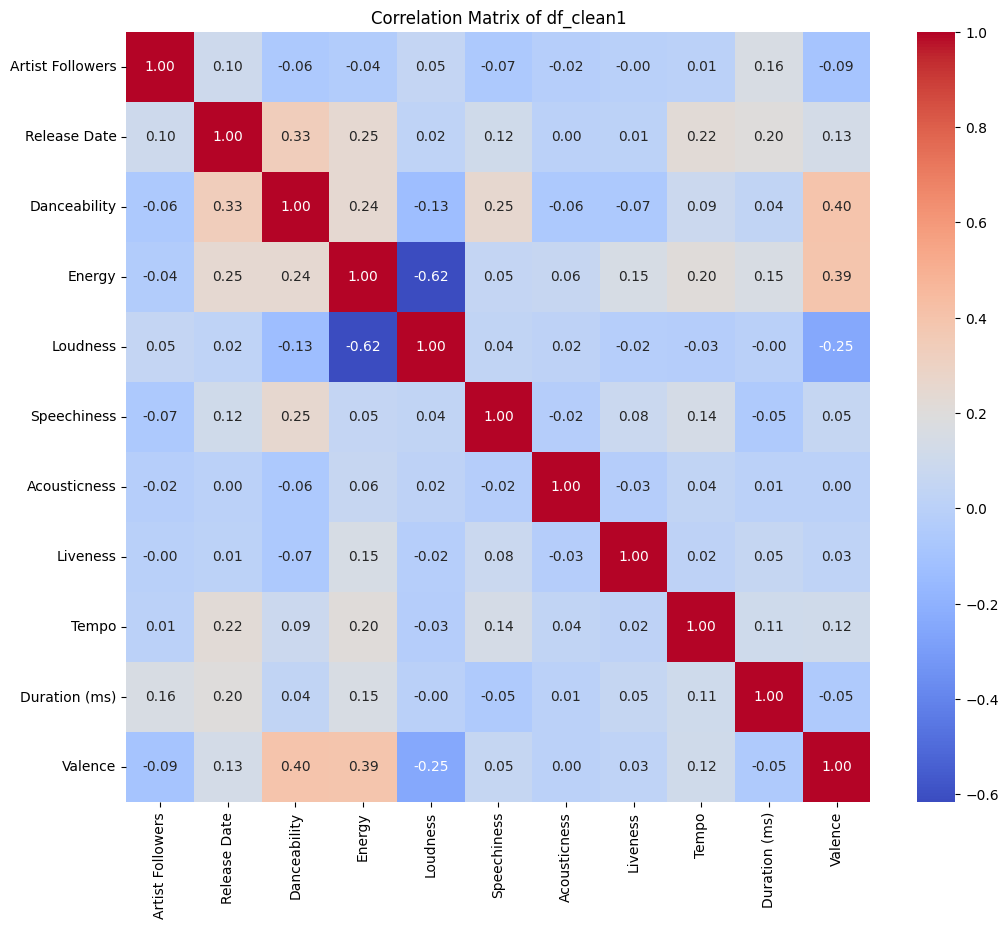

In [33]:
# corr plot of df_clean1

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 10))
sns.heatmap(df_clean1.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of df_clean1')
plt.show()


## Exploratory Data Analysis


- Let's take a look at the target Danceability and Artist Followers

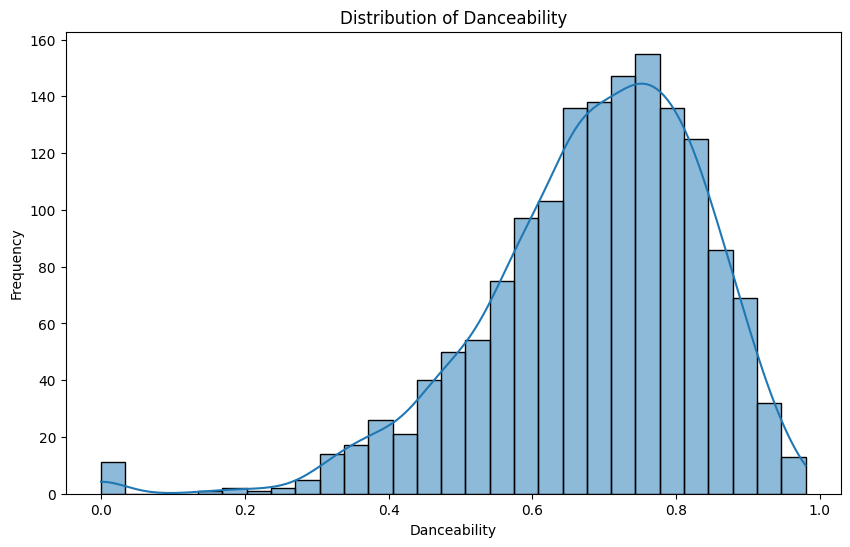

In [34]:
plt.figure(figsize=(10, 6))
sns.histplot(df_clean1['Danceability'], kde=True)  # Use kde=True for a density curve
plt.title('Distribution of Danceability')
plt.xlabel('Danceability')
plt.ylabel('Frequency')
plt.show()


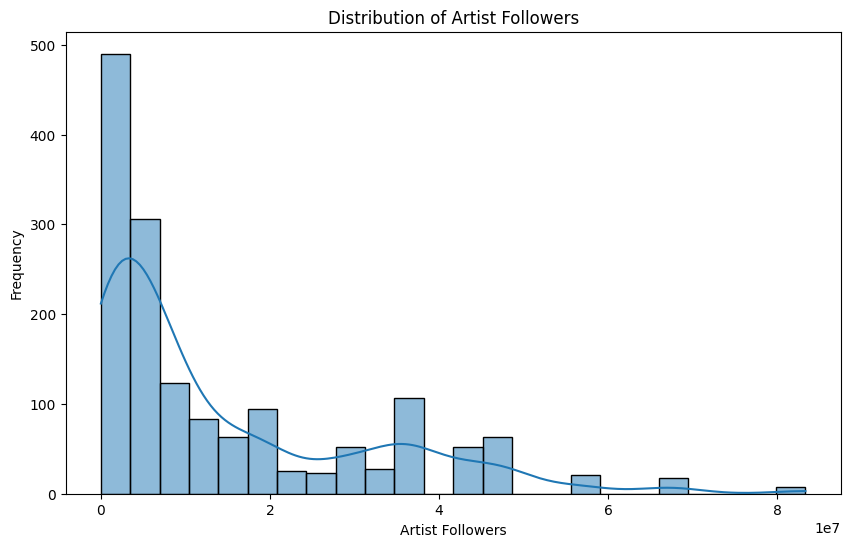

In [35]:
plt.figure(figsize=(10, 6))
sns.histplot(df_clean1['Artist Followers'], kde=True)  # Use kde=True for a density curve
plt.title('Distribution of Artist Followers')
plt.xlabel('Artist Followers')
plt.ylabel('Frequency')
plt.show()


## Processing


### Random Forest Regressor - Danceability target

In [36]:
# split into target and Features

# Define features (X) and target (y)
target = 'Danceability'
X = df_clean1.drop(target, axis=1)  # Features are all columns except
y = df_clean1[target]  # Target variable


In [37]:
# Number of iterations for CV
n = 500
results = np.zeros(n)

for idx in range(n):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=100)

    # Train model
    model = RandomForestRegressor(n_estimators=5, random_state=5)
    model.fit(X_train, y_train)

    # Make predictions and calculate RMSE
    y_pred = model.predict(X_test)
    results[idx] = np.sqrt(mean_squared_error(y_test, y_pred))

# Compute the average RMSE
cv_rmse = results.mean()

# Scale RMSE as a percentage of the mean target value
rmse_percentage = (cv_rmse / np.mean(y)) * 100

# Print results
print(f"CV RMSE: {cv_rmse:.2f}")
print(f"CV RMSE (% of mean target): {rmse_percentage:.2f}%")
print(f"Number of Predictors: {X.shape[1]}")

CV RMSE: 0.12
CV RMSE (% of mean target): 18.08%
Number of Predictors: 10


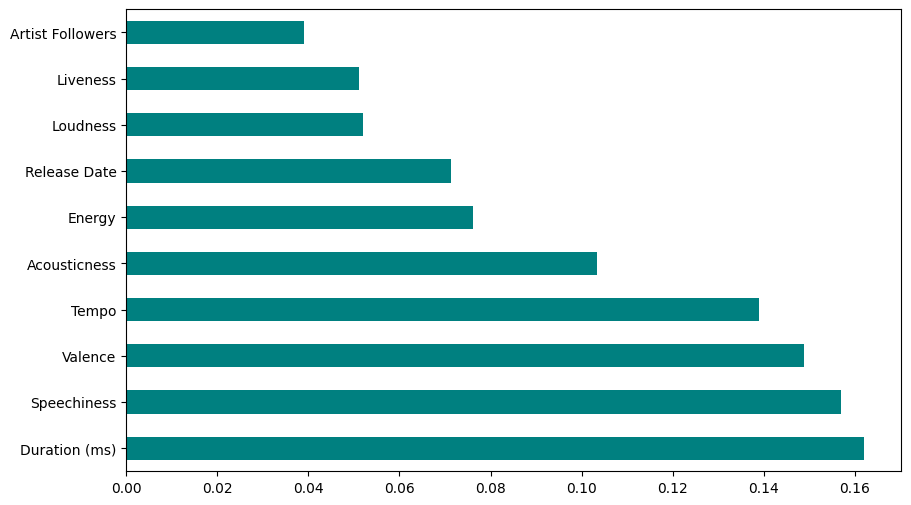

In [38]:
model = RandomForestRegressor()
model.fit(X, y)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh', figsize=(10, 6), color='teal')
plt.show()

### Random Forest Regressor - Artist Followers target

In [39]:
# split into target and Features

# Define features (X) and target (y)

target = 'Artist Followers'
X = df_clean1.drop(target, axis=1)  # Features are all columns except
y = df_clean1[target]  # Target variable

In [40]:
# Number of iterations for CV
n = 500
results = np.zeros(n)

for idx in range(n):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=100)

    # Train model
    model = RandomForestRegressor(n_estimators=5, random_state=5)
    model.fit(X_train, y_train)

    # Make predictions and calculate RMSE
    y_pred = model.predict(X_test)
    results[idx] = np.sqrt(mean_squared_error(y_test, y_pred))

# Compute the average RMSE
cv_rmse = results.mean()

# Scale RMSE as a percentage of the mean target value
rmse_percentage = (cv_rmse / np.mean(y)) * 100

# Print results
print(f"CV RMSE: {cv_rmse:.2f}")
print(f"CV RMSE (% of mean target): {rmse_percentage:.2f}%")
print(f"Number of Predictors: {X.shape[1]}")

CV RMSE: 17351053.80
CV RMSE (% of mean target): 118.74%
Number of Predictors: 10


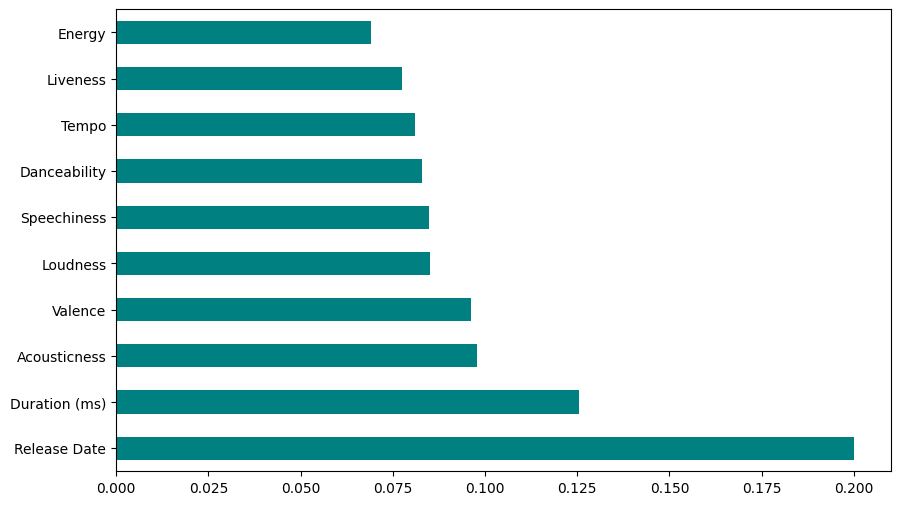

In [41]:
model = RandomForestRegressor()
model.fit(X, y)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh', figsize=(10, 6), color='teal')
plt.show()

- From the looks of it Danceability preformed better than Artist Followers at predicting the song Popularity
- I noticed from the hist plots that Artist Followers had extreme outliers and not normaly distributed.

## Data Visualization/Communication of Results


- Shows Distributions

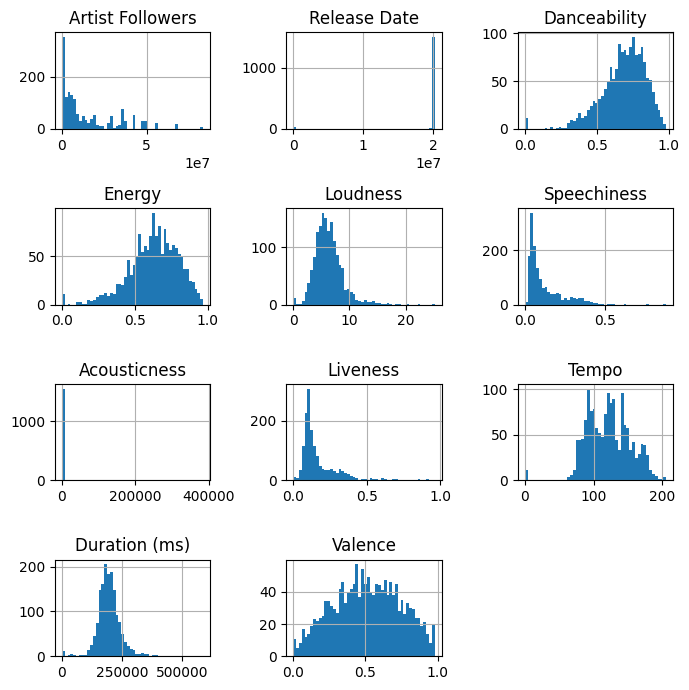

In [42]:
df_clean1.hist(figsize=(7, 7), bins = 50)
plt.tight_layout()
plt.show()

- Shows outliers

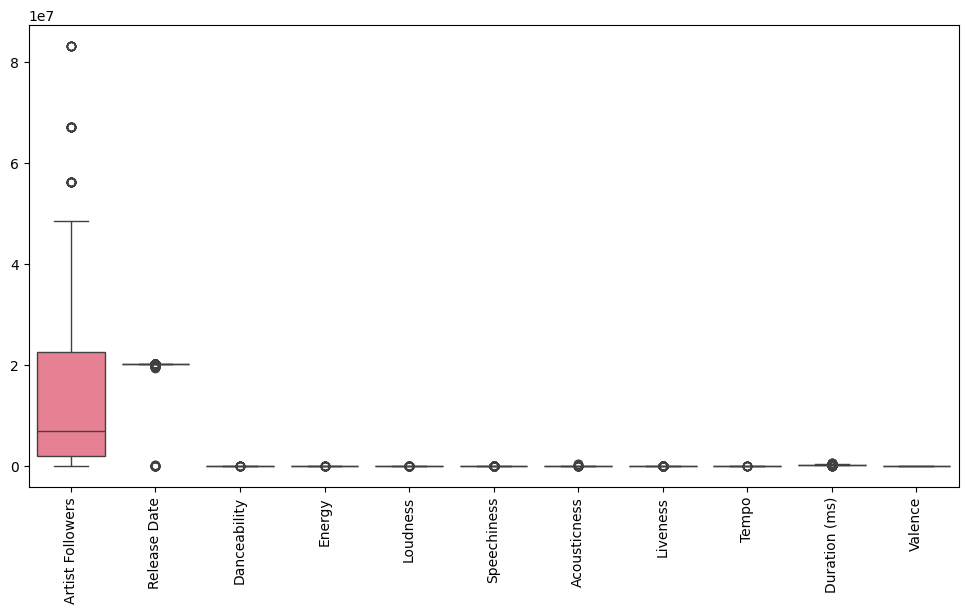

In [43]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_clean1)
plt.xticks(rotation=90)
plt.show()

- Artist Followers has extreme outliers

- Show corralations

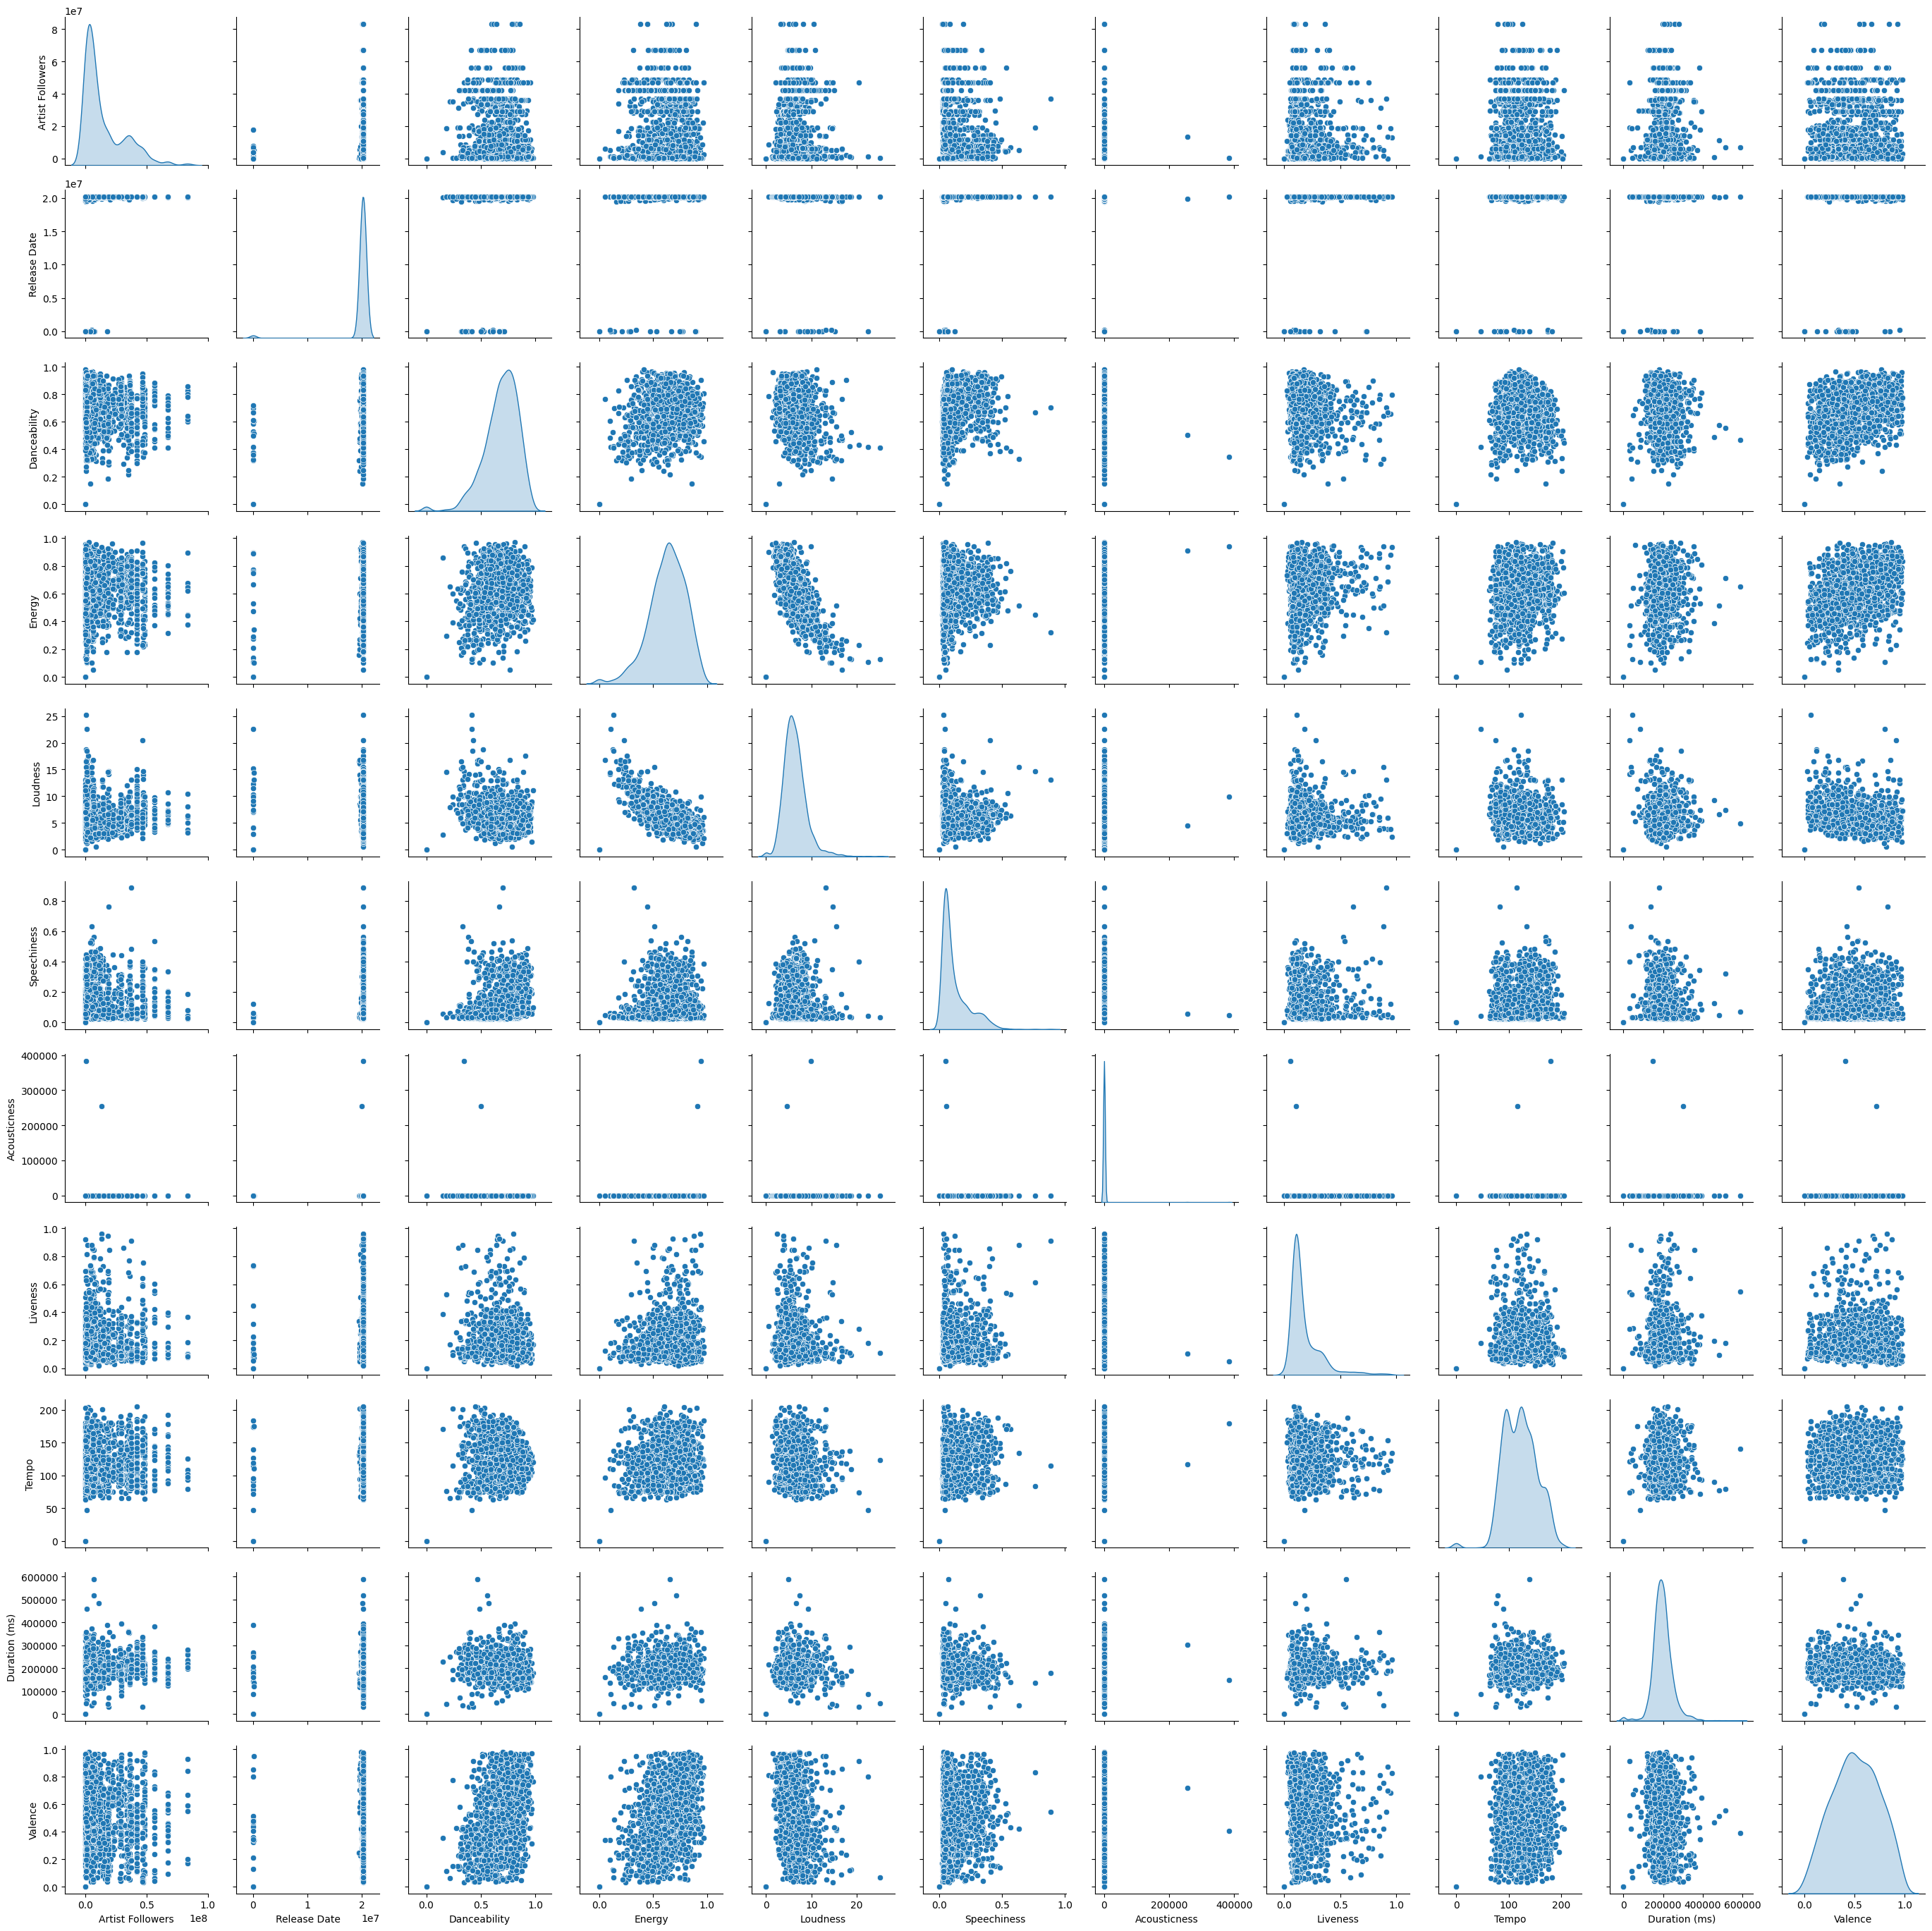

In [44]:
sns.pairplot(df_clean1, diag_kind='kde')
plt.tight_layout()
plt.show()

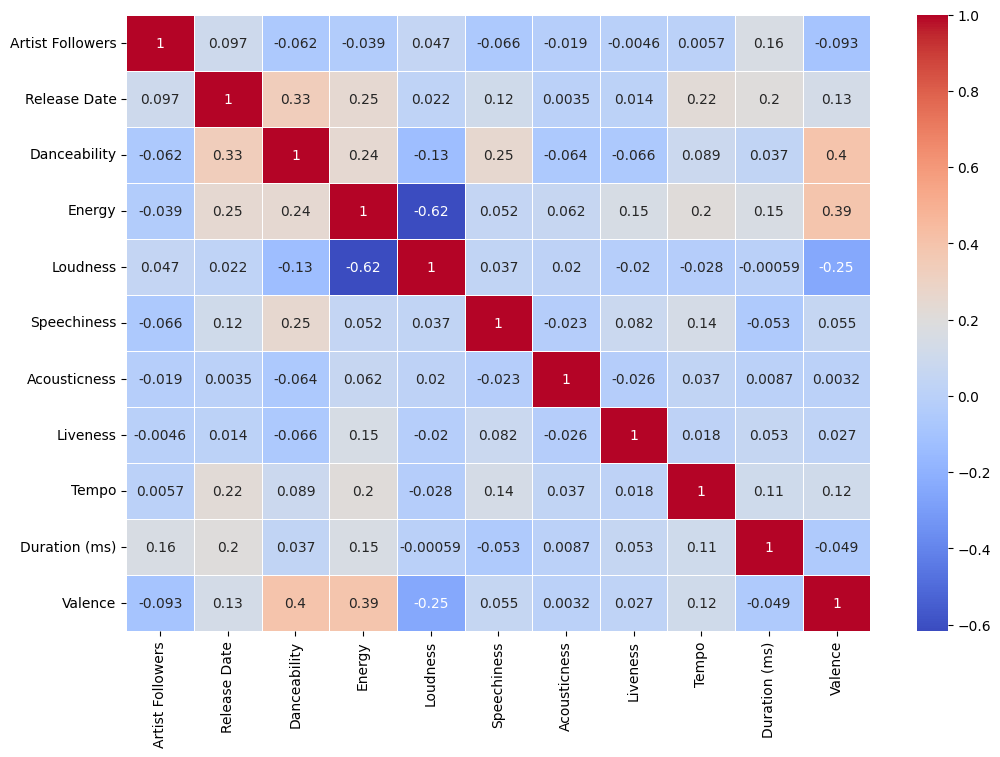

In [45]:
plt.figure(figsize=(12, 8))
sns.heatmap(df_clean1.corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.show()

- Feature Importance with Danceability as target:
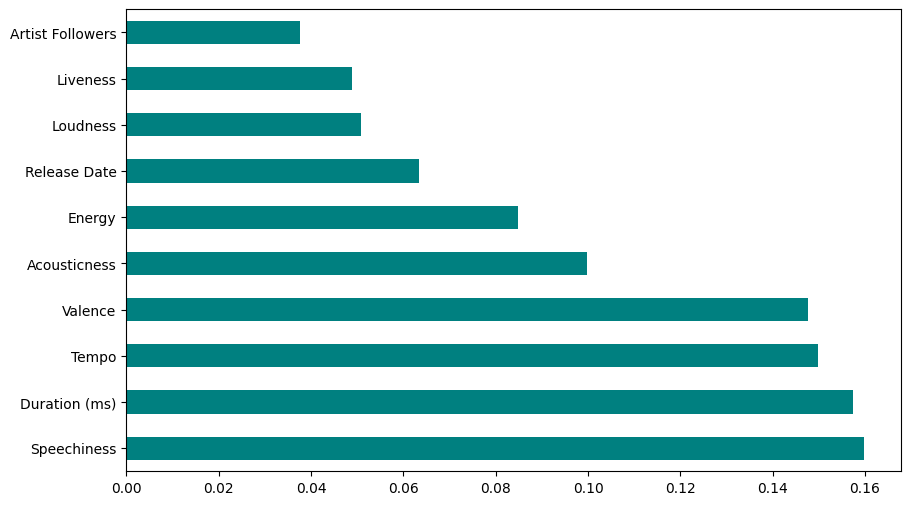


- Feature Importance with Artist Followers as target:

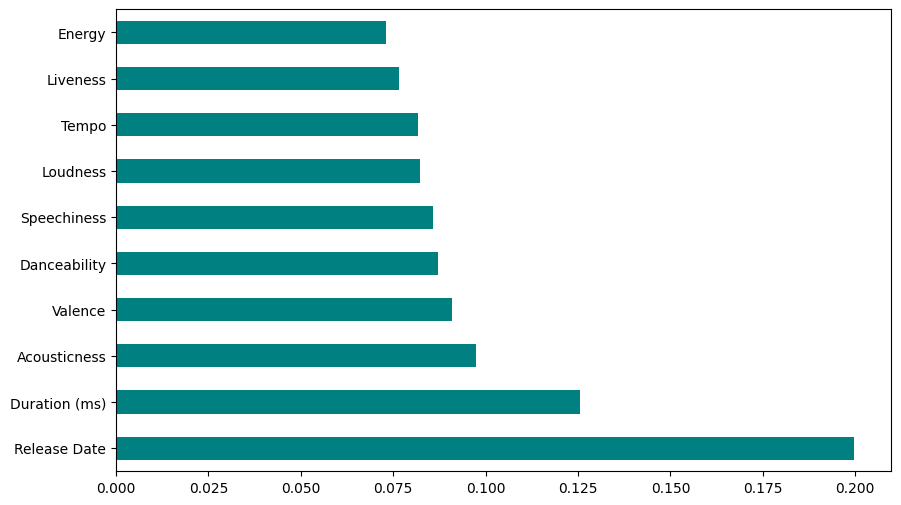

## Conclusion

- Our analysis of Feature Importance reveales that Danceability is a stronger of our target variable compared to Artist Followers. Spotify metric for Dancibility is a combination of elements, including tempo, rhythm and beat; and that these attributes may play a more significant role in predicting its success versus the artist fan base. Think about how many one hit wonders that just had that catchy tune. In my experence, I remember the songs but rarly the artist.
- The finding illistrates that listeners may be more infulenced by how engaging and danceable a track is.
- This can help infuuence Spotify and Music producers prioritize Danceability when selecting singles.
- Some ways I can possibly improve my model is by trying other Regression Tree methods and selecting less features based on feature importance